In [1]:
import os
print(os.getcwd())


C:\Federated_Learning_Project


In [2]:
from pathlib import Path

print("Current directory:", Path.cwd())
print("\nContents of data folder:")

for p in Path("data").iterdir():
    print(" -", p)


Current directory: C:\Federated_Learning_Project

Contents of data folder:
 - data\UCI HAR Dataset


In [3]:
print("\nContents of dataset folder:")

for p in Path("data").glob("*"):
    if p.is_dir():
        print("\nInside:", p)
        for f in p.iterdir():
            print("   ", f)



Contents of dataset folder:

Inside: data\UCI HAR Dataset
    data\UCI HAR Dataset\.DS_Store
    data\UCI HAR Dataset\activity_labels.txt
    data\UCI HAR Dataset\features.txt
    data\UCI HAR Dataset\features_info.txt
    data\UCI HAR Dataset\README.txt
    data\UCI HAR Dataset\test
    data\UCI HAR Dataset\train


In [4]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data/UCI HAR Dataset")

features = pd.read_csv(
    DATA_DIR / "features.txt",
    sep=r"\s+",
    header=None,
    names=["index", "feature"]
)

print("Features loaded:", features.shape)


Features loaded: (561, 2)


In [5]:
# Load train data
X_train = pd.read_csv(
    "data/UCI HAR Dataset/train/X_train.txt",
    sep=r"\s+",
    header=None
)

y_train = pd.read_csv(
    "data/UCI HAR Dataset/train/y_train.txt",
    header=None,
    names=["label"]
)

# Load test data
X_test = pd.read_csv(
    "data/UCI HAR Dataset/test/X_test.txt",
    sep=r"\s+",
    header=None
)

y_test = pd.read_csv(
    "data/UCI HAR Dataset/test/y_test.txt",
    header=None,
    names=["label"]
)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train: (7352, 561)
y_train: (7352, 1)
X_test : (2947, 561)
y_test : (2947, 1)


In [6]:
# Load activity labels
activity_labels = pd.read_csv(
    "data/UCI HAR Dataset/activity_labels.txt",
    sep=r"\s+",
    header=None,
    names=["id", "activity"]
)

# Create mapping
label_map = dict(zip(activity_labels.id, activity_labels.activity))

# Apply mapping
y_train["activity"] = y_train["label"].map(label_map)
y_test["activity"] = y_test["label"].map(label_map)

print(y_train.head())


   label  activity
0      5  STANDING
1      5  STANDING
2      5  STANDING
3      5  STANDING
4      5  STANDING


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test)

print("Scaled train mean (approx 0):", X_train_scaled.mean().round(4))
print("Scaled train std  (approx 1):", X_train_scaled.std().round(4))


Scaled train mean (approx 0): 0.0
Scaled train std  (approx 1): 1.0


In [8]:
import numpy as np

NUM_CLIENTS = 5

# Shuffle training data
indices = np.random.permutation(len(X_train_scaled))
X_shuffled = X_train_scaled[indices]
y_shuffled = y_train["label"].values[indices]

# Split into clients
X_clients = np.array_split(X_shuffled, NUM_CLIENTS)
y_clients = np.array_split(y_shuffled, NUM_CLIENTS)

for i in range(NUM_CLIENTS):
    print(f"Client {i+1}: X = {X_clients[i].shape}, y = {y_clients[i].shape}")


Client 1: X = (1471, 561), y = (1471,)
Client 2: X = (1471, 561), y = (1471,)
Client 3: X = (1470, 561), y = (1470,)
Client 4: X = (1470, 561), y = (1470,)
Client 5: X = (1470, 561), y = (1470,)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_local_model(X, y):
    model = LogisticRegression(
        max_iter=200,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    )
    model.fit(X, y)
    return model
local_models = []

for i in range(NUM_CLIENTS):
    model = train_local_model(X_clients[i], y_clients[i])
    local_models.append(model)
    print(f"Client {i+1} trained")


C:\Users\Divyasri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Client 1 trained


C:\Users\Divyasri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Client 2 trained


C:\Users\Divyasri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Client 3 trained


C:\Users\Divyasri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Client 4 trained


C:\Users\Divyasri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Client 5 trained


In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression

def federated_average(models, all_classes):
    avg_coef = np.mean([m.coef_ for m in models], axis=0)
    avg_intercept = np.mean([m.intercept_ for m in models], axis=0)

    global_model = LogisticRegression(
        max_iter=200,
        solver="lbfgs"
    )

    # Proper initialization with ALL classes
    global_model.classes_ = all_classes
    global_model.coef_ = avg_coef
    global_model.intercept_ = avg_intercept

    return global_model


In [19]:
all_classes = np.unique(y_train["label"])

global_model = federated_average(local_models, all_classes)
print("Global model created with classes:", global_model.classes_)


Global model created with classes: [1 2 3 4 5 6]


In [16]:
print("global_model exists:", "global_model" in globals())


global_model exists: True


In [23]:
from sklearn.metrics import accuracy_score

y_pred = global_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test["label"], y_pred)

print("Global model accuracy:", round(accuracy, 4))


Global model accuracy: 0.9474


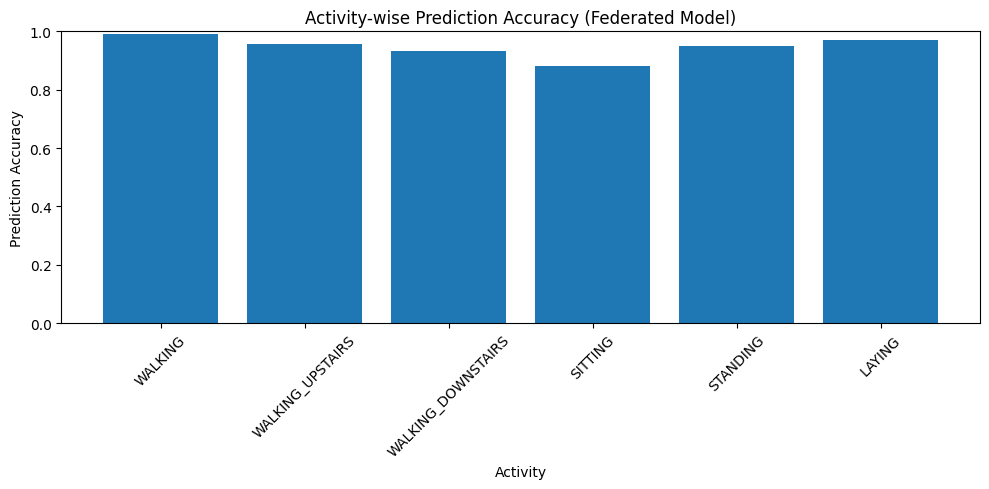

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test["label"], y_pred)

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

activity_names = activity_labels["activity"].tolist()

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(activity_names, class_accuracy)
plt.xticks(rotation=45)
plt.ylabel("Prediction Accuracy")
plt.xlabel("Activity")
plt.title("Activity-wise Prediction Accuracy (Federated Model)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

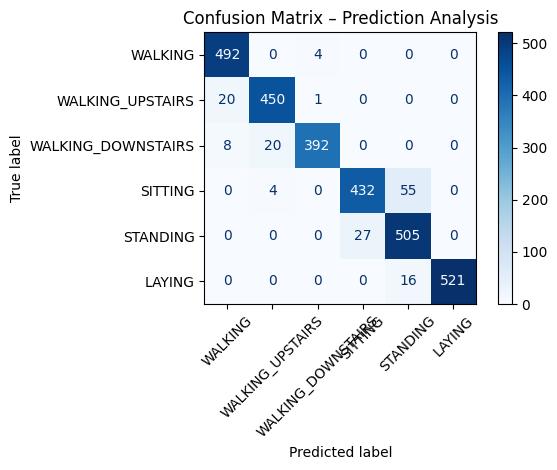

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=activity_names
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix – Prediction Analysis")
plt.tight_layout()
plt.show()


In [26]:
import random

# Pick random test samples
indices = random.sample(range(len(X_test_scaled)), 5)

print("REAL-TIME PREDICTION DEMO\n")

for i in indices:
    true_label = activity_labels.loc[
        activity_labels.id == y_test["label"].iloc[i], "activity"
    ].values[0]
    
    pred_label = activity_labels.loc[
        activity_labels.id == y_pred[i], "activity"
    ].values[0]
    
    print(f"Sample {i}")
    print("Actual Activity   :", true_label)
    print("Predicted Activity:", pred_label)
    print("-" * 40)


REAL-TIME PREDICTION DEMO

Sample 970
Actual Activity   : LAYING
Predicted Activity: LAYING
----------------------------------------
Sample 595
Actual Activity   : WALKING_UPSTAIRS
Predicted Activity: WALKING_UPSTAIRS
----------------------------------------
Sample 2175
Actual Activity   : WALKING_UPSTAIRS
Predicted Activity: WALKING_UPSTAIRS
----------------------------------------
Sample 2617
Actual Activity   : SITTING
Predicted Activity: SITTING
----------------------------------------
Sample 2604
Actual Activity   : SITTING
Predicted Activity: SITTING
----------------------------------------


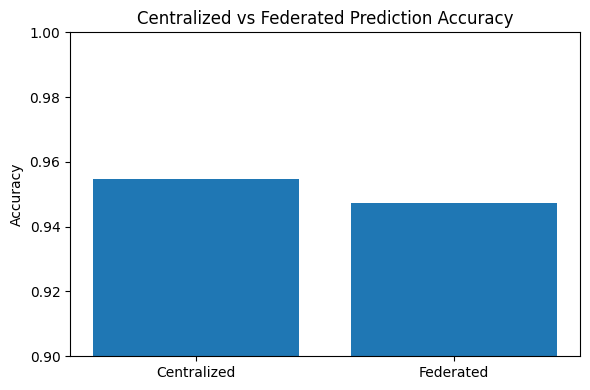

Centralized Accuracy: 0.9549
Federated Accuracy  : 0.9474


In [27]:
# Centralized baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

central_model = LogisticRegression(max_iter=200, solver="lbfgs")
central_model.fit(X_train_scaled, y_train["label"])
central_pred = central_model.predict(X_test_scaled)
central_acc = accuracy_score(y_test["label"], central_pred)

# Plot comparison
plt.figure(figsize=(6, 4))
plt.bar(
    ["Centralized", "Federated"],
    [central_acc, accuracy],
)
plt.ylabel("Accuracy")
plt.title("Centralized vs Federated Prediction Accuracy")
plt.ylim(0.9, 1.0)
plt.tight_layout()
plt.show()

print("Centralized Accuracy:", round(central_acc, 4))
print("Federated Accuracy  :", round(accuracy, 4))


In [28]:
import pandas as pd
import random

# Pick random samples
indices = random.sample(range(len(X_test_scaled)), 8)

rows = []

for i in indices:
    true_label = activity_labels.loc[
        activity_labels.id == y_test["label"].iloc[i], "activity"
    ].values[0]
    
    pred_label = activity_labels.loc[
        activity_labels.id == y_pred[i], "activity"
    ].values[0]
    
    rows.append({
        "Sample ID": i,
        "Actual Activity": true_label,
        "Predicted Activity": pred_label,
        "Correct Prediction": true_label == pred_label
    })

prediction_df = pd.DataFrame(rows)
prediction_df


,Sample ID,Actual Activity,Predicted Activity,Correct Prediction
0,1800,WALKING,WALKING,True
1,1080,SITTING,STANDING,False
2,2121,LAYING,LAYING,True
3,2374,WALKING_UPSTAIRS,WALKING_UPSTAIRS,True
4,2044,STANDING,STANDING,True
5,743,WALKING_UPSTAIRS,WALKING_UPSTAIRS,True
6,2177,WALKING_UPSTAIRS,WALKING_UPSTAIRS,True
7,2227,STANDING,STANDING,True


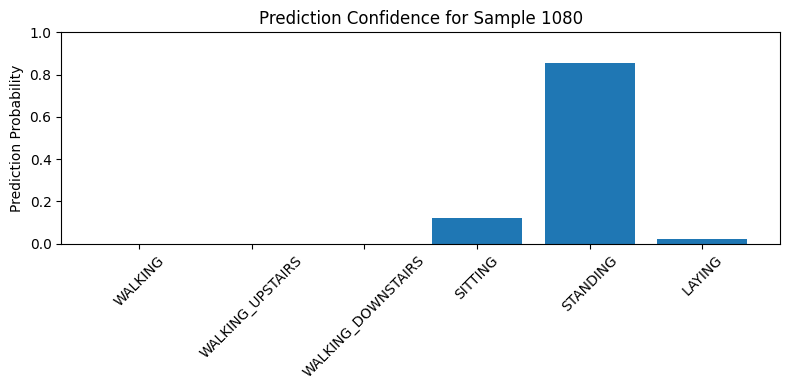

Actual Activity   : SITTING
Predicted Activity: STANDING


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Pick ONE sample
i = random.choice(indices)

probs = global_model.predict_proba(X_test_scaled[i].reshape(1, -1))[0]
activities = activity_labels["activity"].tolist()

plt.figure(figsize=(8, 4))
plt.bar(activities, probs)
plt.xticks(rotation=45)
plt.ylabel("Prediction Probability")
plt.title(f"Prediction Confidence for Sample {i}")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("Actual Activity   :", activity_labels.loc[
    activity_labels.id == y_test['label'].iloc[i], "activity"
].values[0])

print("Predicted Activity:", activity_labels.loc[
    activity_labels.id == y_pred[i], "activity"
].values[0])


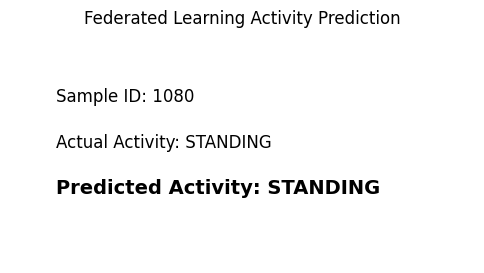

In [30]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("off")

ax.text(0.1, 0.7, f"Sample ID: {i}", fontsize=12)
ax.text(0.1, 0.5, f"Actual Activity: {true_label}", fontsize=12)
ax.text(0.1, 0.3, f"Predicted Activity: {pred_label}", fontsize=14, weight="bold")

plt.title("Federated Learning Activity Prediction")
plt.show()


In [31]:
import numpy as np
import joblib
import os

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Save test data
np.save("results/X_test_scaled.npy", X_test_scaled)

# Save test labels
y_test.to_csv("results/y_test.csv", index=False)

# Save trained global model
joblib.dump(global_model, "results/global_model.pkl")

print("✅ Model and test data saved successfully")


✅ Model and test data saved successfully
